In a previous notebook, I explored the various classical statistical techniques for forecasting the total sales of Paris Metro tickets. That notebook can be found in this same repository. In this notebook we will tackle the same problem, but with neural network based techniques. As a brief history, the M- Series forecasting challenges showed that many deep learning techniques, while theoretically superior, were outperformed by the classical statistical techniques. Today we will see if this still holds true, or if neural networks can beat our previously best performing model - exponential smoothing. We quickly reproduce those results below.

In [59]:
# General Imports
import pandas as pd
import numpy as np


# Specific Imports

from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from sklearn.metrics import mean_squared_error
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, Informer, TimesNet

print("Done")

Done


In [6]:
df = pd.read_csv('Paris_Metro_Traffic_Tickets.csv')
df

,DATE,M032ECFRM452NNBR
0,1930-03-01,62.82
1,1930-04-01,58.44
2,1930-05-01,60.32
3,1930-06-01,53.36
4,1930-07-01,50.12
...,...,...
89,1937-08-01,44.57
90,1937-09-01,55.19
91,1937-10-01,62.21
92,1937-11-01,56.98


In [7]:
# Same procedure as previous notebook

df.rename(columns={"M032ECFRM452NNBR":'y', 'DATE':'ds'}, inplace= True)
df.insert(loc= 0, column='unique_id',value='Tickets')
train_df = df.loc[0:60].copy()
test_df = df.loc[61:].copy()
train_df["ds"]=pd.to_datetime(train_df["ds"])


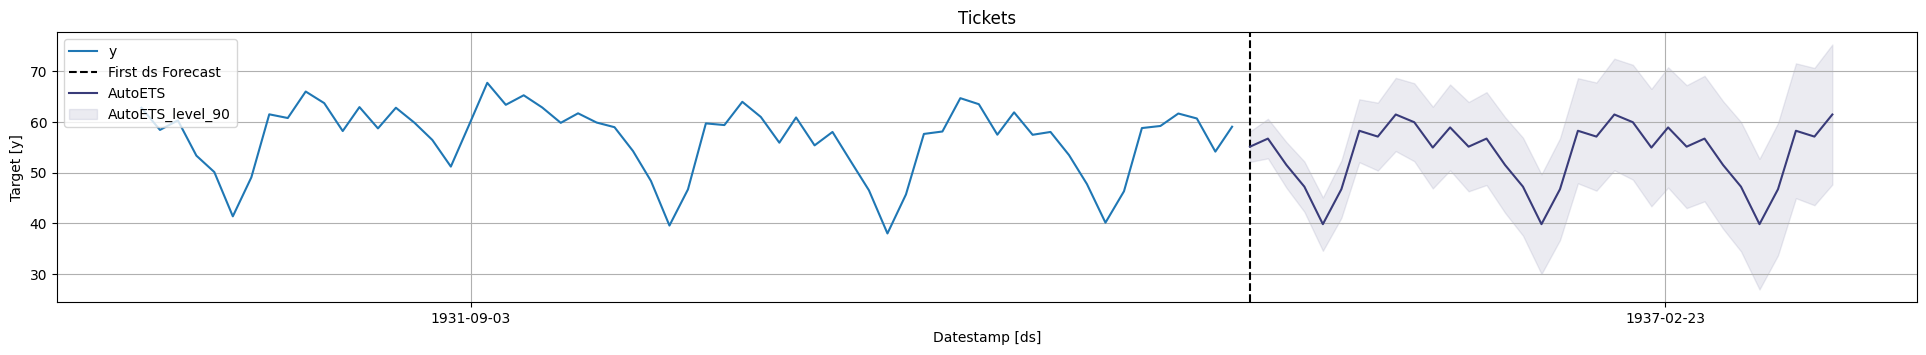

In [8]:
# Exponential Smoothing Model

sf = StatsForecast(
    models = [AutoETS(season_length=12)],
    freq = 'M'
)

sf.fit(train_df)

forecast_df = sf.predict(h=33, level=[90])

sf.plot(train_df, forecast_df, level=[90], engine='matplotlib')


In [9]:
# Test Error
mean_squared_error(test_df['y'],forecast_df['AutoETS'])

6.143417049003517

A MSE of ~ 6.14 is the score to beat. We first try a Long Short Term Memory (LSTM) Recurrent Neural Network, the natural choice for a problem of this kind.

In [ ]:
models = [LSTM(h=33,                         # Forecast horizon
               max_steps=500,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,)     # Defines the number of hidden units of each layer of the MLP decoder
          ]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=train_df)

In [ ]:
forecast_df = nf.predict()
forecast_df.head()

In [26]:
mean_squared_error(test_df['y'],forecast_df['LSTM'])

8.031878017072819

The LSTM produces score of 8.03, which while respectable, still does not beat our Exponential Smoothing Model. Next, we will try a Transformer, which is essentially the state of the art architecture across many domains at this point in time. We will specifically use the 'Informer', which is one of the most succesful adaptations of the transformers architecture to time-series tasks. It is described in-depth in this paper: https://arxiv.org/abs/2012.07436

In [ ]:
models = [Informer(h=33,
                   input_size= 24,
                   scaler_type='standard',
                   max_steps = 500,
                   val_check_steps = 10,
                   learning_rate= 1e-3
                   )
          ]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=train_df)
forecast_df = nf.predict()


In [56]:
mean_squared_error(test_df['y'],forecast_df['Informer'])

11.987773043337244

Not a bad result, but still not enough. While the Informer may be the SOTA for Transformer-Based models, since the Informer, there have been a number of subsequent improvements on benchmarks, starting with the "N-BEATS", a model described in this paper by Yoshua Bengio and others: https://arxiv.org/abs/1905.10437. As we follow the N-Beats lineage, we end up with "NHITS", which is currently the SOTA. It is described here: (https://arxiv.org/abs/2201.12886). We apply it below.

In [ ]:
models = [NHITS(h=33,
                input_size= 24,
                scaler_type='standard',
                max_steps = 500,
                val_check_steps = 10,
                learning_rate= 1e-3
                )
          ]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=train_df)
forecast_df = nf.predict()


In [58]:
mean_squared_error(test_df['y'],forecast_df['NHITS'])

12.967215729125432

NHITS performs about the same as the Informer, but they still don't come close to our target. We could, of course, keep trying out similar models such as the "Autoformer" or "N-Beatsx", and hope for better results, but it is doubtful we get such a significant improvment needed to beat our target, given we are already using SOTA models. Instead, we try out a SOTA model based on a different type of Architecture, a CNN approach, the 'Timesnet'. Details can be found here: https://arxiv.org/abs/2210.02186.

In [ ]:
models = [TimesNet(h=33,
                input_size= 24,
                scaler_type='standard',
                max_steps = 50,
                val_check_steps = 10,
                learning_rate= 1e-3
                )
          ]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=train_df)
forecast_df = nf.predict()


In [64]:
mean_squared_error(test_df['y'],forecast_df['TimesNet'])

22.36554583601851

Unfortunately, this model disapointed. In conclusion, no Deep Learning model was able to outperform the Exponential Smoothing model. In fact, the simple LSTM was the better performing over any of the fancy SOTA methods which took hours to train! This just goes to show that sometimes, the old ways truly do work best.